# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [406]:
# 清空所有變數
%reset -f
# # 強制 Python 回收記憶體
# import gc
# gc.collect()

### Package


In [407]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
from datetime import datetime
import json


### Hyperparameter Config

In [408]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 1500
    BATCH_SIZE = 256
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 100
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30
    MAXOUT_H = 1


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [409]:
material = "CH467160"
fix_way = "perChannelScaling_MLP"
note = "Augmentation_Test5"
note_detail = "alpha=0.5、先家初始點再加數據增強、batchsize=256、只跑90度"
downsample = 1024
save_figure = True
timestamp = datetime.now().strftime("%Y%m%d")

# 訓練情況況
plot_interval = 100
train_show_sample = 1

result_dir = os.path.join("results",
                          f"{timestamp}_{fix_way}_{material}_{note}")
os.makedirs(result_dir, exist_ok=True)

# 定義保存模型的路徑
model_save_dir = result_dir
model_save_path = os.path.join(
    model_save_dir, f"{material}_{fix_way}_{note}_{timestamp}.pt")  # 定義模型保存檔名

figure_save_base_path = result_dir

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [410]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   n_init=16):

    # Data pre-process

    # ── 0. 全域設定/降階設定 ──────────────────────────────
    eps = 1e-8  # 防止除以 0
    if downsample == 1024:
        seq_length = 1024  # 單筆波形點數 (不再 down-sample)
    else:
        seq_length = downsample
        cols = np.linspace(0, 1023, seq_length, dtype=int)
        data_B = data_B[:, cols]
        data_H = data_H[:, cols]

    # ── 1. 波形拼接 (補 n_init 點作初始磁化) ────
    data_length = seq_length + n_init
    data_B = np.hstack((data_B[:, -n_init:], data_B))  # (batch, data_length)
    data_H = np.hstack((data_H[:, -n_init:], data_H))

    # ── 數據增強：相位位移 90 度和 180 度 ───────────────
    # # 原數據
    # data_B_orig = data_B.copy()
    # data_H_orig = data_H.copy()

    # # 90 度位移 (256 點)
    # data_B_90 = np.roll(data_B, shift=256, axis=1)
    # data_H_90 = np.roll(data_H, shift=256, axis=1)

    # # 180 度位移 (512 點)
    # data_B_180 = np.roll(data_B, shift=512, axis=1)
    # data_H_180 = np.roll(data_H, shift=512, axis=1)

    # # 合併數據
    # data_B = np.vstack([data_B_orig, data_B_90,
    #                     data_B_180])  # 形狀從 (N, 1024) 變為 (3N, 1024)
    # data_H = np.vstack([data_H_orig, data_H_90, data_H_180])

    # # 對應的純量特徵也要複製三次
    # data_F = np.repeat(data_F, 3, axis=0)  # (3N,)
    # data_T = np.repeat(data_T, 3, axis=0)
    # data_Hdc = np.repeat(data_Hdc, 3, axis=0)
    # data_N = np.repeat(data_N, 3, axis=0)
    # data_Pcv = np.repeat(data_Pcv, 3, axis=0)

    # # 90 度位移 (256 點)
    # data_B_90 = np.roll(data_B, shift=256, axis=1)
    # data_H_90 = np.roll(data_H, shift=256, axis=1)

    # # 合併數據
    # data_B = np.vstack([data_B_orig, data_B_90])  # 形狀從 (N, 1024) 變為 (3N, 1024)
    # data_H = np.vstack([data_H_orig, data_H_90])

    # # 對應的純量特徵也要複製三次
    # data_F = np.repeat(data_F, 2, axis=0)  # (3N,)
    # data_T = np.repeat(data_T, 2, axis=0)
    # data_Hdc = np.repeat(data_Hdc, 2, axis=0)
    # data_N = np.repeat(data_N, 2, axis=0)
    # data_Pcv = np.repeat(data_Pcv, 2, axis=0)

    # 只做 90 度位移 (shift=256)，不保留原始
    data_B_90 = np.roll(data_B, shift=256, axis=1)  # (N, data_length)
    data_H_90 = np.roll(data_H, shift=256, axis=1)

    # 直接讓資料 = 位移後的版本
    data_B = data_B_90.copy()  # (N, data_length)
    data_H = data_H_90.copy()

    print("B shape:", data_B.shape)
    print("H shape:", data_H.shape)
    print("F shape:", data_F.shape)
    print("T shape:", data_T.shape)
    print("Hdc shape:", data_Hdc.shape)
    print("N shape:", data_N.shape)
    print("Pcv shape:", data_Pcv.shape)

    # ── 2. 轉成 Tensor ───────────────────────────
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()  # (B,N,1)
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())  # 純量
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # ── 3. 每筆樣本各自找最大幅值 (per-profile scale) ─
    scale_B = torch.max(torch.abs(B), dim=1,
                        keepdim=True).values + eps  # (B,1,1)
    scale_H = torch.max(torch.abs(H), dim=1, keepdim=True).values + eps

    # ── 4. 先計算導數，再除以 scale_B ─────────────
    dB = torch.diff(B, dim=1, prepend=B[:, :1])
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))  # 真實斜率
    d2B = torch.diff(dB, dim=1, prepend=dB[:, :1])
    d2B_dt = d2B * (seq_length * F.view(-1, 1, 1))

    # ── 5. 形成模型輸入 (已經縮放到 [-1,1]) ────────
    in_B = B / scale_B
    out_H = H / scale_H  # 預測目標
    in_dB_dt = dB_dt / scale_B
    in_d2B_dt = d2B_dt / scale_B

    # ── 6. 純量特徵：計算 z-score 參數 ─────────────
    def safe_mean_std(tensor, eps=1e-8):
        m = torch.mean(tensor).item()
        s = torch.std(tensor).item()
        return [m, 1.0 if s < eps else s]

    #  Compute normalization parameters (均值 & 標準差)**
    norm = [
        safe_mean_std(F),
        safe_mean_std(T),
        safe_mean_std(Hdc),
        safe_mean_std(N),
        safe_mean_std(Pcv)
    ]

    # 用來做test固定標準化參數的
    print("0.F, 1.T, 2.Hdc, 3.N, 4.Pcv")
    material_name = f"{material}"
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")

    # Data Normalization
    in_F = (F - norm[0][0]) / norm[0][1]  # F
    in_T = (T - norm[1][0]) / norm[1][1]  # T
    in_Hdc = (Hdc - norm[2][0]) / norm[2][1]  # Hdc
    in_N = (N - norm[3][0]) / norm[3][1]  # N
    in_Pcv = (Pcv - norm[4][0]) / norm[4][1]  # Pcv

    #   → 方便推論復原，保留 scale_B, scale_H 當作額外純量
    aux_features = torch.cat(
        (in_F, in_T, in_Hdc, in_N, in_Pcv, scale_B.squeeze(-1),
         scale_H.squeeze(-1)),  # (batch, 7)
        dim=1)

    # ── 7. 產生初始 Preisach operator 狀態 s0 ──────
    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)
    s0 = get_operator_init(in_B[:, 0] - dB[:, 0] / scale_B.squeeze(-1),
                           dB / scale_B, max_B, min_B)

    # ── 8. 組合 Dataset ───────────────────────────
    wave_inputs = torch.cat(
        (
            in_B,  # ① B
            dB / scale_B,  # ② ΔB
            in_dB_dt,  # ③ dB/dt
            in_d2B_dt),
        dim=2)  # ④ d²B/dt²   → (B,L,4)

    aux_features = torch.cat((in_F, in_T, in_Hdc, in_N), dim=1)  # (B,4)
    amps = torch.cat((scale_B.squeeze(-1), scale_H.squeeze(-1)),
                     dim=1)  # (B,2)

    # 這裡把 Pcv（已 z-score）單獨拿出來當另一個 label
    target_Pcv = in_Pcv  # (B,1)

    full_dataset = torch.utils.data.TensorDataset(
        wave_inputs,  # 0  → 模型序列輸入
        aux_features,  # 1  → 4 個純量
        amps,  # 2  → 幅值係數
        s0,  # 3  → Preisach 初始狀態
        out_H,  # 4  → 目標 H  (已 scale_H)
        target_Pcv)  # 5  → 目標 Pcv (已 z-score)

    # ── 9. Train / Valid split & DataLoader ───────
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size
    train_set, valid_set = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        #    num_workers=4,
        pin_memory=True,
        collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(
        valid_set,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        #    num_workers=4,
        pin_memory=True,
        collate_fn=filter_input)

    return train_loader, valid_loader, norm


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=Config.MAXOUT_H,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, amps, s0, target_H, target_Pcv = zip(*batch)

    inputs = torch.stack(inputs)  # (B,L,4)
    features = torch.stack(features)  # (B,4)
    amps = torch.stack(amps)
    s0 = torch.stack(s0)
    target_H = torch.stack(target_H)[:, -downsample:, :]  # 保留全長
    target_Pcv = torch.stack(target_Pcv)  # (B,1)

    # return inputs, features, s0, target_H, target_Pcv
    return inputs, features, amps, s0, target_H, target_Pcv


# 溫度頻率不變加入微小的 epsilon
def safe_mean_std(tensor, eps=1e-8):
    m_tensor = torch.mean(tensor)  # 還是 Tensor
    s_tensor = torch.std(tensor)  # 還是 Tensor

    m_val = m_tensor.item()  # 第一次轉成 float
    s_val = s_tensor.item()
    if s_val < eps:
        s_val = 1.0
    return [m_val, s_val]  # 直接回傳 float


## Step2: Define Network Structure

In [411]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt 4.d2B/dt)
    - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
    
    只先把d2B/dt考量在EddyCell裡面
"""


class MMINet(nn.Module):

    def __init__(
            self,
            norm,
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=4,  #!新增d2B(250203)
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + self.var_size, 1)
        #!250520更新：5 (F, T, B, dB/dt, d2B/dt ) + 2 (Hdc, N)
        self.rnn2 = EddyCell(7, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)
        self.rnn2_hx = None

        self.loss_mlp = nn.Sequential(
            nn.Linear(self.var_size + 1,
                      64),  # var_size=4: F, T, Hdc, N + 1 for P_prelim
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(32, 1))

    def forward(self, x, var, amps, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
# !       - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # !Initialize DNN2 input (1.B 2.dB/dt 3.d2B)
        # x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)
        # !選取 B, dB/dt, d2B/dt
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:4]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        amp_B = amps[:, 0:1]  # (batch,1)
        amp_H = amps[:, 1:2]  # (batch,1)
        B_amp = x[:, n_init:, 0:1] * amp_B.unsqueeze(1)
        H_amp = output[:, n_init:, :] * amp_H.unsqueeze(1)
        P_prelim = torch.trapz(H_amp, B_amp, axis=1) * (10**(
            var[:, 0:1] * self.norm[0][1] + self.norm[0][0]))
        Pcv_log = torch.log10(P_prelim.clamp(min=1e-12))
        Pcv = (Pcv_log - self.norm[4][0]) / self.norm[4][1]
        mlp_input = torch.cat((var, Pcv), dim=1)  # (batch, 5)
        s = self.loss_mlp(mlp_input)
        Pcv_mlp = Pcv + s

        return H, Pcv_mlp


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(Config.MAXOUT_H / operator_size, Config.MAXOUT_H,
                        operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Step3: Training the Model

### Load Dataset

In [412]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file2 = f"{base_path}{material}/train/Frequency.csv"
    in_file3 = f"{base_path}{material}/train/Temperature.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"
    in_file5 = f"{base_path}{material}/train/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/train/Hdc.csv"  # *250317新增：直流偏置磁場
    in_file7 = f"{base_path}{material}/train/Turns.csv"  # *250317新增：匝數

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N


### Train Logger

In [413]:
class TrainLogger:

    def __init__(self, exp_name, config_dict, result_dir):
        self.exp_name = exp_name
        self.result_dir = result_dir
        self.config = config_dict
        os.makedirs(self.result_dir, exist_ok=True)

        self._save_config()
        self._write_metadata()

    def _save_config(self):
        with open(os.path.join(self.result_dir, "config.json"), "w") as f:
            json.dump(self.config, f, indent=2, ensure_ascii=False)

    def _write_metadata(self):
        metadata = {
            "experiment_name": self.exp_name,
            "timestamp": datetime.now().isoformat()
        }
        with open(os.path.join(self.result_dir, "meta.json"), "w") as f:
            json.dump(metadata, f, indent=2)

    def save_summary(self, best_epoch, best_val_loss, best_loss_H,
                     best_loss_Pcv, model_save_path, elapsed):
        summary = {
            "exp_name": self.exp_name,
            "timestamp": datetime.now().isoformat(),
            "duration_sec": elapsed,
            "config": self.config,
            "best_model": {
                "path": model_save_path,
                "epoch": best_epoch,
                "val_loss": best_val_loss,
                "loss_H": best_loss_H,
                "loss_Pcv": best_loss_Pcv
            },
            "note": note,
            "note detail": note_detail
        }
        with open(os.path.join(self.result_dir, "summary.json"), "w") as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)

### Train Code

In [414]:
def train_model(norm, train_loader, valid_loader, logger):

    start_time = time.perf_counter()
    model = MMINet(norm=norm).to(device)
    print("=== Start Train  ===")
    print(r"""
    (\_/)
    ( •_•)
    / > 拜託順利阿
    """)
    print("Number of parameters: ", count_parameters(model))

    criterion_H = nn.MSELoss()
    criterion_Pcv = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    # Loss 記錄
    best_val_loss = float('inf')
    best_loss_Pcv = float('inf')
    best_loss_H = float('inf')
    # Early stopping 紀錄
    patience_counter = 0
    train_losses = []
    val_losses = []
    fixed_idx = None
    # 保存每個 epoch 的時間
    epoch_times = []
    # Logger 紀錄
    best_epoch = 0

    for epoch in range(Config.NUM_EPOCHS):
        t0 = time.perf_counter()

        model.train()
        train_loss = 0

        for inputs, features, amps, s0, target_H, target_Pcv in train_loader:

            inputs, features, amps, s0, target_H, target_Pcv = inputs.to(
                device), features.to(device), amps.to(device), s0.to(
                    device), target_H.to(device), target_Pcv.to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type="cuda"):
                outputs_H, outputs_Pcv = model(inputs, features, amps,
                                               s0)  # 模型的輸出
                loss_H = criterion_H(outputs_H, target_H)  # 使用真實的 H(t) 計算損失
                loss_Pcv = criterion_Pcv(outputs_Pcv, target_Pcv)
                # if epoch < 1000:
                #     loss = loss_H
                # else:
                #     alpha = (epoch + 1) / Config.NUM_EPOCHS
                #     loss = (1 - alpha) * loss_H + alpha * loss_Pcv
                alpha = 0.5
                # alpha = (epoch + 1) / Config.NUM_EPOCHS
                loss = (1 - alpha) * loss_H + alpha * loss_Pcv
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        # ------------------------------vaildation------------------------------

        model.eval()
        val_loss = 0
        val_loss_H = 0.0
        val_loss_Pcv = 0.0

        with torch.no_grad():
            for inputs, features, amps, s0, target_H, target_Pcv in valid_loader:
                inputs, features, amps, s0, target_H, target_Pcv = inputs.to(
                    device), features.to(device), amps.to(device), s0.to(
                        device), target_H.to(device), target_Pcv.to(device)

                outputs_H, outputs_Pcv = model(inputs, features, amps,
                                               s0)  # 模型的輸出
                loss_H = criterion_H(outputs_H, target_H)  # 使用真實的 H(t) 計算損失
                loss_Pcv = criterion_Pcv(outputs_Pcv, target_Pcv)
                # if epoch < 1000:
                #     loss = loss_H
                # else:
                #     alpha = (epoch + 1) / Config.NUM_EPOCHS
                #     loss = (1 - alpha) * loss_H + alpha * loss_Pcv

                # alpha = (epoch + 1) / Config.NUM_EPOCHS
                alpha = 0.5
                loss = (1 - alpha) * loss_H + alpha * loss_Pcv

                val_loss += loss.item()
                val_loss_H += loss_H.item()
                val_loss_Pcv += loss_Pcv.item()

        # 求驗證集平均
        val_loss_H /= len(valid_loader)
        val_loss_Pcv /= len(valid_loader)
        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        # ─── 計算並輸出這個 epoch 的耗時 ───────────
        te = time.perf_counter() - t0
        epoch_times.append(te)
        print(f"---")
        print(f"alpha: {alpha:.3f}")
        print(
            f"Epoch {epoch+1}, loss_H: {val_loss_H :.6f}, loss_Pcv: {val_loss_Pcv:.6f}"
        )
        print(
            f"Epoch {epoch+1} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {te:.2f}s"
        )
        print(
            f"(Best Epoch {best_epoch} | best H: {best_loss_H:.6f}| best Pcv: {best_loss_Pcv:.6f}| val_loss : {val_loss:.6f})"
        )

        # ======================================================繪製訓練情況======================================================

        if (epoch + 1) % plot_interval == 0:

            # 第一次產生固定的隨機索引
            if fixed_idx is None:
                batch_size_fix = 3
                fixed_idx = torch.randperm(batch_size_fix)[:train_show_sample]

            # # -------------------------設定圖表H(t)比較---------------------------------------

            # outputs = [fixed_idx, :downsample,
            #  0].detach().cpu().numpy()
            # targets_np = target_H[fixed_idx, :downsample,
            #                       0].detach().cpu().numpy()

            # plt.figure(figsize=(12, 6))

            # for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
            #     plt.plot(outputs[i, :, 0],
            #              label=f"Pred: Sample {i+1}",
            #              linestyle='--',
            #              marker='o')
            #     plt.plot(targets[i, :, 0],
            #              label=f"Target: Sample {i+1}",
            #              linestyle='-',
            #              marker='x')

            # # 添加標題和標籤
            # plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            # plt.xlabel("Index", fontsize=14)
            # plt.ylabel("Value", fontsize=14)
            # plt.legend(loc="upper right", fontsize=12)
            # plt.grid(alpha=0.5)

            # # 顯示圖表
            # plt.show()
            # # -------------------------設定圖表H(t)比較 結束---------------------------------------

            # # -------------------------設定圖表B-H比較---------------------------------------
            # 取對應 sample
            outputs_np = outputs_H[fixed_idx, -downsample:,
                                   0].detach().cpu().numpy()
            targets_np = target_H[fixed_idx, -downsample:,
                                  0].detach().cpu().numpy()
            B_seq_np = inputs[fixed_idx, -downsample:,
                              0].detach().cpu().numpy()

            # 設定圖表
            plt.figure()

            for i in range(train_show_sample):  # 每一批數據繪製一個圖表
                plt.plot(outputs_np[i],
                         B_seq_np[i],
                         label=f"Pred: Sample {i+1}",
                         markersize=1)

                plt.plot(targets_np[i],
                         B_seq_np[i],
                         label=f"Target: Sample {i+1}",
                         alpha=0.5)

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.grid(alpha=0.5)
            plt.legend()
            if save_figure == True:
                figure_save_path1 = os.path.join(
                    figure_save_base_path,
                    f"Compare_Epoch {epoch + 1}.svg")  # 定義模型保存檔名
                plt.savefig(figure_save_path1)
            plt.show()
            # # -------------------------設定圖表B-H比較 END---------------------------------------
        # ======================================================繪製訓練情況  END ======================================================

        # ======================================================Early stop======================================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_loss_H = val_loss_H
            best_loss_Pcv = val_loss_Pcv
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"→Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1
            print(
                f"  無改善，patience_counter = {patience_counter}/{Config.EARLY_STOPPING_PATIENCE}"
            )

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

        # # 考量 H 跟 Pcv
        # improved = False

        # # 只要 H-loss 有更低，就視為「H 改善」
        # if val_loss_H < best_val_loss_H:
        #     best_val_loss_H = val_loss_H
        #     improved = True

        # # 只要 Pcv-loss 有更低，就視為「Pcv 改善」
        # if val_loss_Pcv < best_val_loss_Pcv:
        #     best_val_loss_Pcv = val_loss_Pcv
        #     improved = True

        # if improved:
        #     best_epoch = epoch + 1
        #     # 同時更新「儲存最佳模型」
        #     torch.save(model.state_dict(), model_save_path)
        #     print(
        #         f"  → Saving model at epoch {epoch+1} "
        #         f"(best H: {best_val_loss_H:.6f}, best Pcv: {best_val_loss_Pcv:.6f})"
        #     )
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     print(
        #         f"  無改善，patience_counter = {patience_counter}/{Config.EARLY_STOPPING_PATIENCE}"
        #     )

        # # 當 patience_counter 超過設定，才觸發 Early Stopping
        # if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
        #     print("Early stopping triggered.")
        #     break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")
    elapsed = time.perf_counter() - start_time  # ← 訓練結束，計算耗時
    hrs = int(elapsed // 3600)
    mins = int((elapsed % 3600) // 60)
    secs = elapsed % 60
    print(f"訓練總耗時：{hrs} 小時 {mins} 分 {secs:.2f} 秒")
    logger.save_summary(best_epoch, best_val_loss, best_loss_H, best_loss_Pcv,
                        model_save_path, elapsed)

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1,
              len(train_losses) + 1),
        train_losses,
        label="Train Loss",
    )
    plt.plot(range(1,
                   len(val_losses) + 1),
             val_losses,
             label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(alpha=0.5)
    if save_figure == True:
        # 將圖表保存為 SVG 格式
        figure_save_path2 = os.path.join(figure_save_base_path,
                                         "Training_Validation_Loss_Curve.svg")
        plt.savefig(figure_save_path2)
    plt.show()
    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, amps, s0, target_H, target_Pcv in valid_loader:
            inputs, features, amps, s0, target_H, target_Pcv = inputs.to(
                device), features.to(device), amps.to(device), s0.to(
                    device), target_H.to(device), target_Pcv.to(device)

            outputs_H, outputs_Pcv = model(inputs, features, amps, s0)
            break  # 只使用一批驗證數據進行可視化

    # 選取對應資料（index tensor 要先轉 list 才能 index numpy）
    outputs_np = outputs_H[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    targets_np = target_H[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    B_seq_np = inputs[fixed_idx, -downsample:, 0].detach().cpu().numpy()

    # 設定圖表
    plt.figure()

    for i in range(train_show_sample):  # 每一批數據繪製一個圖表
        plt.plot(outputs_np[i], B_seq_np[i], label=f"Pred: Sample {i+1}")

        plt.plot(targets_np[i],
                 B_seq_np[i],
                 label=f"Target: Sample {i+1}",
                 alpha=0.7)

    # 添加標題和標籤
    plt.title(f"Best Model - Predicted vs Target")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(alpha=0.5)
    plt.legend()
    if save_figure == True:
        figure_save_path3 = os.path.join(
            figure_save_base_path,
            "Best Model_Predicted vs Target.svg")  # 定義模型保存檔名
        plt.savefig(figure_save_path3)

    # ===================================使用最佳模型來產生驗證結果 END=============================

### Start Train!!!

In [415]:
def main():
    # # 這段放在檔案最前面（import 之後）
    # BASE_DIR = Path(__file__).resolve().parent
    # os.chdir(BASE_DIR)
    # print("👉 Switch CWD to script folder:", os.getcwd())

    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_N, data_Hdc,
                                                      data_Pcv)

    # ---- 印第一個 batch 檢查 ----
    # # inputs, features, s0, target_H, target_Pcv = next(iter(train_loader))
    # inputs, features, amps, s0, target_H, target_Pcv = next(iter(train_loader))

    # print("=== Batch shape check ===")
    # print(f"inputs      : {inputs.shape}")  # (batch, seq_len, 4)
    # print(f"features    : {features.shape}")  # (batch, 4)
    # print(f"s0          : {s0.shape}")  # (batch, operator_size)
    # print(f"target_H    : {target_H.shape}")  # (batch, seq_len, 1)
    # # print(f"target_Pcv  : {target_Pcv.shape}")  # (batch, 1)
    # print()

    # # 選一筆樣本看看數值範圍
    # idx = 0
    # print("範例 inputs[0] (前 3 個時間點):")
    # print(inputs[idx, :3, :])  # B, ΔB, dB/dt, d²B/dt² (已歸一化到 ~[-1,1])
    # print("範例 features[0]:", features[idx])  # F, T, Hdc, N (已 z-score)
    # print("範例 s0[0]:", s0[idx, :5])  # 前 5 個 Preisach operator 狀態
    # print("範例 target_H[0] (前 3 點):", target_H[idx, :3, 0])
    # # print("範例 target_Pcv[0]:", target_Pcv[idx, 0])

    # 產生 Logger（放在 train_model 前）

    logger = TrainLogger(
        exp_name=f"{material}_{note}_{timestamp}",
        config_dict={
            k: getattr(Config, k)
            for k in dir(Config)
            if not k.startswith('__') and not callable(getattr(Config, k))
        },
        result_dir=result_dir)

    train_model(norm, train_loader, valid_loader, logger)  # logger

    # train_model(norm, train_loader, valid_loader)

B shape: (2418, 1040)
H shape: (2418, 1040)
F shape: (2418,)
T shape: (2418,)
Hdc shape: (2418,)
N shape: (2418,)
Pcv shape: (2418,)
0.F, 1.T, 2.Hdc, 3.N, 4.Pcv
"CH467160": [
    [2.0, 1.0],
    [25.0, 1.0],
    [1245.2510986328125, 698.5667114257812],
    [14.20181941986084, 4.4452033042907715],
    [1.6664491891860962, 0.7449064254760742],
]
=== Start Train  ===

    (\_/)
    ( •_•)
    / > 拜託順利阿
    
Number of parameters:  3673
---
alpha: 0.500
Epoch 1, loss_H: 0.981897, loss_Pcv: 0.840294
Epoch 1 | Train Loss: 3.589564 | Val Loss: 0.911096 | Time: 5.11s
(Best Epoch 0 | best H: inf| best Pcv: inf| val_loss : 0.911096)
→Saving model at epoch 1 with validation loss 0.911096...
---
alpha: 0.500
Epoch 2, loss_H: 0.948083, loss_Pcv: 0.470702
Epoch 2 | Train Loss: 0.830910 | Val Loss: 0.709393 | Time: 5.42s
(Best Epoch 1 | best H: 0.981897| best Pcv: 0.840294| val_loss : 0.709393)
→Saving model at epoch 2 with validation loss 0.709393...
---
alpha: 0.500
Epoch 3, loss_H: 0.908050, loss_P

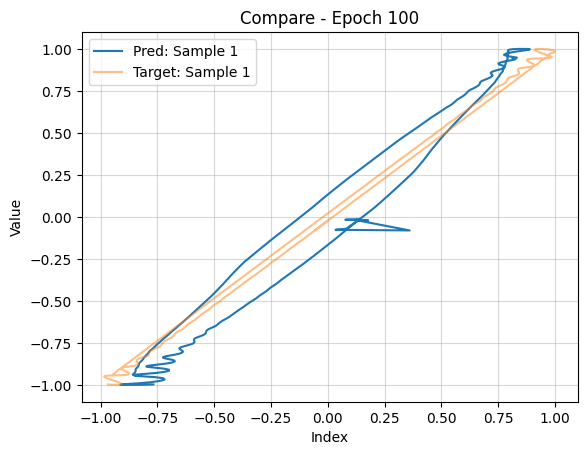

→Saving model at epoch 100 with validation loss 0.012746...
---
alpha: 0.500
Epoch 101, loss_H: 0.010189, loss_Pcv: 0.014744
Epoch 101 | Train Loss: 0.012928 | Val Loss: 0.012466 | Time: 5.16s
(Best Epoch 100 | best H: 0.010448| best Pcv: 0.015045| val_loss : 0.012466)
→Saving model at epoch 101 with validation loss 0.012466...
---
alpha: 0.500
Epoch 102, loss_H: 0.009962, loss_Pcv: 0.014416
Epoch 102 | Train Loss: 0.012706 | Val Loss: 0.012189 | Time: 5.39s
(Best Epoch 101 | best H: 0.010189| best Pcv: 0.014744| val_loss : 0.012189)
→Saving model at epoch 102 with validation loss 0.012189...
---
alpha: 0.500
Epoch 103, loss_H: 0.009751, loss_Pcv: 0.014193
Epoch 103 | Train Loss: 0.012506 | Val Loss: 0.011972 | Time: 5.19s
(Best Epoch 102 | best H: 0.009962| best Pcv: 0.014416| val_loss : 0.011972)
→Saving model at epoch 103 with validation loss 0.011972...
---
alpha: 0.500
Epoch 104, loss_H: 0.009532, loss_Pcv: 0.014037
Epoch 104 | Train Loss: 0.013033 | Val Loss: 0.011784 | Time: 5.2

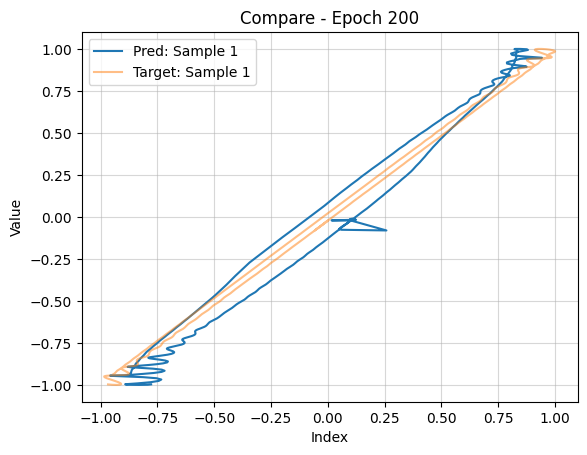

→Saving model at epoch 200 with validation loss 0.008769...
---
alpha: 0.500
Epoch 201, loss_H: 0.006721, loss_Pcv: 0.010836
Epoch 201 | Train Loss: 0.009293 | Val Loss: 0.008778 | Time: 5.04s
(Best Epoch 200 | best H: 0.006719| best Pcv: 0.010819| val_loss : 0.008778)
  無改善，patience_counter = 1/100
---
alpha: 0.500
Epoch 202, loss_H: 0.006715, loss_Pcv: 0.010857
Epoch 202 | Train Loss: 0.009295 | Val Loss: 0.008786 | Time: 5.26s
(Best Epoch 200 | best H: 0.006719| best Pcv: 0.010819| val_loss : 0.008786)
  無改善，patience_counter = 2/100
---
alpha: 0.500
Epoch 203, loss_H: 0.006697, loss_Pcv: 0.010888
Epoch 203 | Train Loss: 0.009953 | Val Loss: 0.008792 | Time: 5.48s
(Best Epoch 200 | best H: 0.006719| best Pcv: 0.010819| val_loss : 0.008792)
  無改善，patience_counter = 3/100
---
alpha: 0.500
Epoch 204, loss_H: 0.006691, loss_Pcv: 0.010833
Epoch 204 | Train Loss: 0.009942 | Val Loss: 0.008762 | Time: 4.99s
(Best Epoch 200 | best H: 0.006719| best Pcv: 0.010819| val_loss : 0.008762)
→Saving

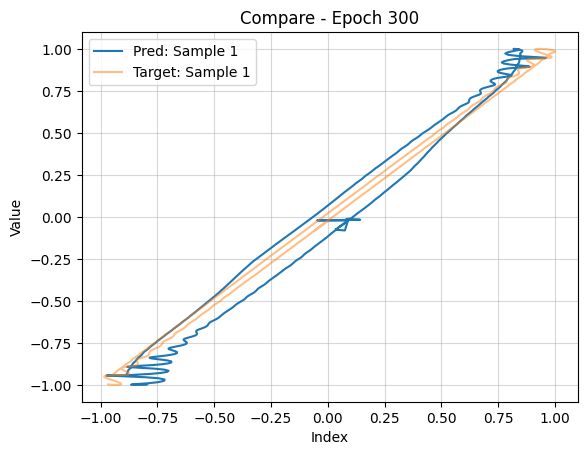

  無改善，patience_counter = 6/100
---
alpha: 0.500
Epoch 301, loss_H: 0.005607, loss_Pcv: 0.010605
Epoch 301 | Train Loss: 0.008475 | Val Loss: 0.008106 | Time: 5.13s
(Best Epoch 294 | best H: 0.005662| best Pcv: 0.010563| val_loss : 0.008106)
→Saving model at epoch 301 with validation loss 0.008106...
---
alpha: 0.500
Epoch 302, loss_H: 0.005615, loss_Pcv: 0.010633
Epoch 302 | Train Loss: 0.008515 | Val Loss: 0.008124 | Time: 5.00s
(Best Epoch 301 | best H: 0.005607| best Pcv: 0.010605| val_loss : 0.008124)
  無改善，patience_counter = 1/100
---
alpha: 0.500
Epoch 303, loss_H: 0.005571, loss_Pcv: 0.010539
Epoch 303 | Train Loss: 0.008493 | Val Loss: 0.008055 | Time: 5.14s
(Best Epoch 301 | best H: 0.005607| best Pcv: 0.010605| val_loss : 0.008055)
→Saving model at epoch 303 with validation loss 0.008055...
---
alpha: 0.500
Epoch 304, loss_H: 0.005591, loss_Pcv: 0.010604
Epoch 304 | Train Loss: 0.008450 | Val Loss: 0.008097 | Time: 5.22s
(Best Epoch 303 | best H: 0.005571| best Pcv: 0.010539|

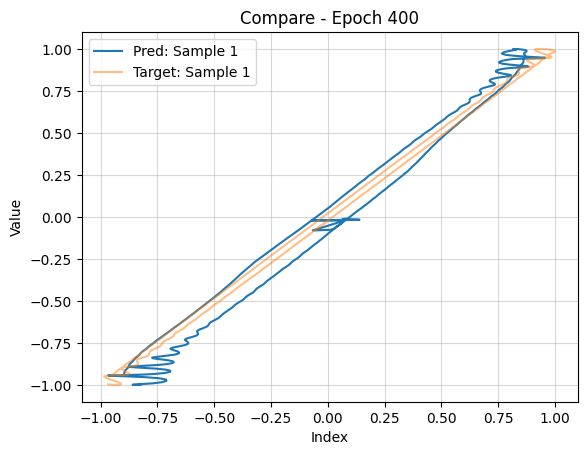

  無改善，patience_counter = 2/100
---
alpha: 0.500
Epoch 401, loss_H: 0.004753, loss_Pcv: 0.010468
Epoch 401 | Train Loss: 0.007900 | Val Loss: 0.007611 | Time: 5.13s
(Best Epoch 398 | best H: 0.004723| best Pcv: 0.010320| val_loss : 0.007611)
  無改善，patience_counter = 3/100
---
alpha: 0.500
Epoch 402, loss_H: 0.004703, loss_Pcv: 0.010294
Epoch 402 | Train Loss: 0.010025 | Val Loss: 0.007498 | Time: 5.23s
(Best Epoch 398 | best H: 0.004723| best Pcv: 0.010320| val_loss : 0.007498)
→Saving model at epoch 402 with validation loss 0.007498...
---
alpha: 0.500
Epoch 403, loss_H: 0.004693, loss_Pcv: 0.010361
Epoch 403 | Train Loss: 0.007892 | Val Loss: 0.007527 | Time: 4.93s
(Best Epoch 402 | best H: 0.004703| best Pcv: 0.010294| val_loss : 0.007527)
  無改善，patience_counter = 1/100
---
alpha: 0.500
Epoch 404, loss_H: 0.004625, loss_Pcv: 0.010619
Epoch 404 | Train Loss: 0.008596 | Val Loss: 0.007622 | Time: 5.43s
(Best Epoch 402 | best H: 0.004703| best Pcv: 0.010294| val_loss : 0.007622)
  無改善，p

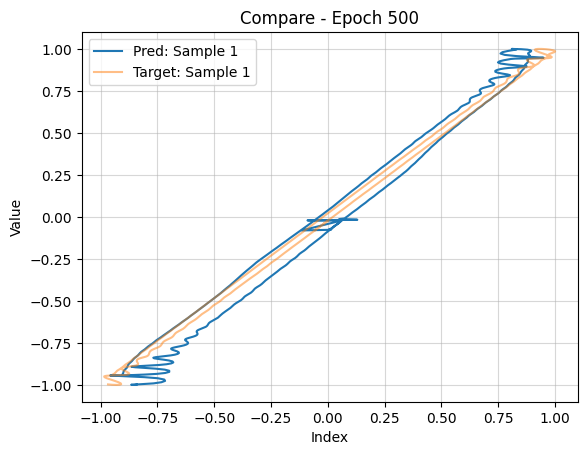

  無改善，patience_counter = 4/100
---
alpha: 0.500
Epoch 501, loss_H: 0.004160, loss_Pcv: 0.010085
Epoch 501 | Train Loss: 0.007463 | Val Loss: 0.007122 | Time: 5.01s
(Best Epoch 496 | best H: 0.004146| best Pcv: 0.009926| val_loss : 0.007122)
  無改善，patience_counter = 5/100
---
alpha: 0.500
Epoch 502, loss_H: 0.004110, loss_Pcv: 0.010062
Epoch 502 | Train Loss: 0.008127 | Val Loss: 0.007086 | Time: 4.99s
(Best Epoch 496 | best H: 0.004146| best Pcv: 0.009926| val_loss : 0.007086)
  無改善，patience_counter = 6/100
---
alpha: 0.500
Epoch 503, loss_H: 0.004081, loss_Pcv: 0.010122
Epoch 503 | Train Loss: 0.008153 | Val Loss: 0.007102 | Time: 5.19s
(Best Epoch 496 | best H: 0.004146| best Pcv: 0.009926| val_loss : 0.007102)
  無改善，patience_counter = 7/100
---
alpha: 0.500
Epoch 504, loss_H: 0.004097, loss_Pcv: 0.010006
Epoch 504 | Train Loss: 0.007475 | Val Loss: 0.007052 | Time: 4.94s
(Best Epoch 496 | best H: 0.004146| best Pcv: 0.009926| val_loss : 0.007052)
  無改善，patience_counter = 8/100
---
a

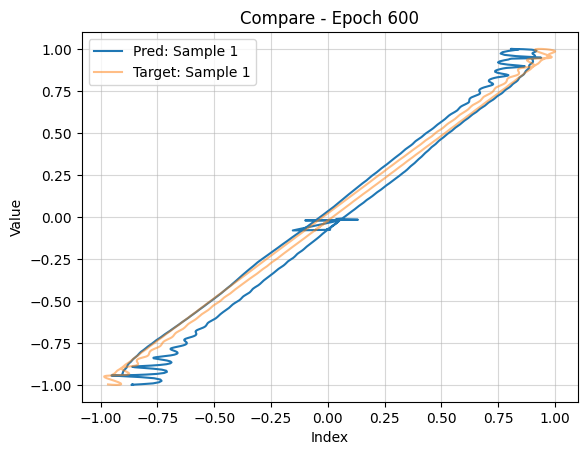

→Saving model at epoch 600 with validation loss 0.006726...
---
alpha: 0.500
Epoch 601, loss_H: 0.003720, loss_Pcv: 0.010107
Epoch 601 | Train Loss: 0.007167 | Val Loss: 0.006913 | Time: 5.22s
(Best Epoch 600 | best H: 0.003692| best Pcv: 0.009759| val_loss : 0.006913)
  無改善，patience_counter = 1/100
---
alpha: 0.500
Epoch 602, loss_H: 0.003638, loss_Pcv: 0.009926
Epoch 602 | Train Loss: 0.007804 | Val Loss: 0.006782 | Time: 5.25s
(Best Epoch 600 | best H: 0.003692| best Pcv: 0.009759| val_loss : 0.006782)
  無改善，patience_counter = 2/100
---
alpha: 0.500
Epoch 603, loss_H: 0.003616, loss_Pcv: 0.010028
Epoch 603 | Train Loss: 0.007144 | Val Loss: 0.006822 | Time: 5.22s
(Best Epoch 600 | best H: 0.003692| best Pcv: 0.009759| val_loss : 0.006822)
  無改善，patience_counter = 3/100
---
alpha: 0.500
Epoch 604, loss_H: 0.003675, loss_Pcv: 0.009926
Epoch 604 | Train Loss: 0.007065 | Val Loss: 0.006800 | Time: 5.18s
(Best Epoch 600 | best H: 0.003692| best Pcv: 0.009759| val_loss : 0.006800)
  無改善，p

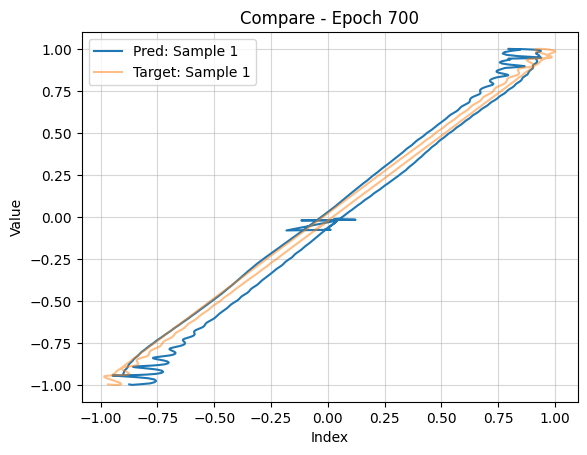

→Saving model at epoch 700 with validation loss 0.006477...
---
alpha: 0.500
Epoch 701, loss_H: 0.003278, loss_Pcv: 0.010762
Epoch 701 | Train Loss: 0.006943 | Val Loss: 0.007020 | Time: 5.04s
(Best Epoch 700 | best H: 0.003353| best Pcv: 0.009600| val_loss : 0.007020)
  無改善，patience_counter = 1/100
---
alpha: 0.500
Epoch 702, loss_H: 0.003399, loss_Pcv: 0.009797
Epoch 702 | Train Loss: 0.007769 | Val Loss: 0.006598 | Time: 5.25s
(Best Epoch 700 | best H: 0.003353| best Pcv: 0.009600| val_loss : 0.006598)
  無改善，patience_counter = 2/100
---
alpha: 0.500
Epoch 703, loss_H: 0.003284, loss_Pcv: 0.010093
Epoch 703 | Train Loss: 0.007481 | Val Loss: 0.006689 | Time: 5.06s
(Best Epoch 700 | best H: 0.003353| best Pcv: 0.009600| val_loss : 0.006689)
  無改善，patience_counter = 3/100
---
alpha: 0.500
Epoch 704, loss_H: 0.003382, loss_Pcv: 0.009862
Epoch 704 | Train Loss: 0.006820 | Val Loss: 0.006622 | Time: 5.19s
(Best Epoch 700 | best H: 0.003353| best Pcv: 0.009600| val_loss : 0.006622)
  無改善，p

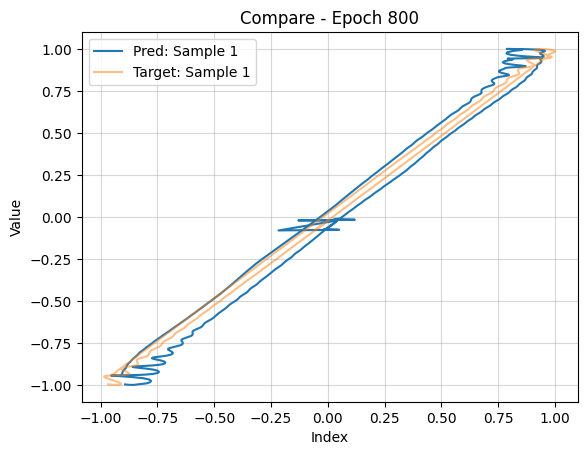

  無改善，patience_counter = 3/100
---
alpha: 0.500
Epoch 801, loss_H: 0.002978, loss_Pcv: 0.011457
Epoch 801 | Train Loss: 0.007606 | Val Loss: 0.007218 | Time: 5.19s
(Best Epoch 797 | best H: 0.003123| best Pcv: 0.009429| val_loss : 0.007218)
  無改善，patience_counter = 4/100
---
alpha: 0.500
Epoch 802, loss_H: 0.003211, loss_Pcv: 0.010029
Epoch 802 | Train Loss: 0.006880 | Val Loss: 0.006620 | Time: 5.04s
(Best Epoch 797 | best H: 0.003123| best Pcv: 0.009429| val_loss : 0.006620)
  無改善，patience_counter = 5/100
---
alpha: 0.500
Epoch 803, loss_H: 0.003104, loss_Pcv: 0.009442
Epoch 803 | Train Loss: 0.006720 | Val Loss: 0.006273 | Time: 5.30s
(Best Epoch 797 | best H: 0.003123| best Pcv: 0.009429| val_loss : 0.006273)
→Saving model at epoch 803 with validation loss 0.006273...
---
alpha: 0.500
Epoch 804, loss_H: 0.002980, loss_Pcv: 0.010771
Epoch 804 | Train Loss: 0.007421 | Val Loss: 0.006875 | Time: 5.24s
(Best Epoch 803 | best H: 0.003104| best Pcv: 0.009442| val_loss : 0.006875)
  無改善，p

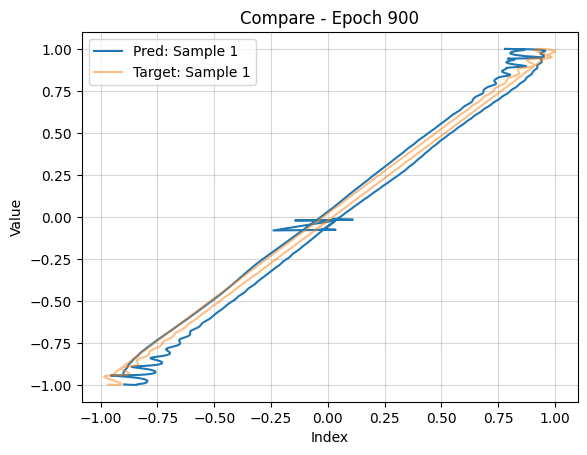

  無改善，patience_counter = 1/100
---
alpha: 0.500
Epoch 901, loss_H: 0.003046, loss_Pcv: 0.009602
Epoch 901 | Train Loss: 0.006798 | Val Loss: 0.006324 | Time: 5.08s
(Best Epoch 899 | best H: 0.002911| best Pcv: 0.009345| val_loss : 0.006324)
  無改善，patience_counter = 2/100
---
alpha: 0.500
Epoch 902, loss_H: 0.003064, loss_Pcv: 0.009857
Epoch 902 | Train Loss: 0.006539 | Val Loss: 0.006461 | Time: 5.21s
(Best Epoch 899 | best H: 0.002911| best Pcv: 0.009345| val_loss : 0.006461)
  無改善，patience_counter = 3/100
---
alpha: 0.500
Epoch 903, loss_H: 0.002919, loss_Pcv: 0.009406
Epoch 903 | Train Loss: 0.007105 | Val Loss: 0.006162 | Time: 4.97s
(Best Epoch 899 | best H: 0.002911| best Pcv: 0.009345| val_loss : 0.006162)
  無改善，patience_counter = 4/100
---
alpha: 0.500
Epoch 904, loss_H: 0.002999, loss_Pcv: 0.009749
Epoch 904 | Train Loss: 0.006498 | Val Loss: 0.006374 | Time: 5.28s
(Best Epoch 899 | best H: 0.002911| best Pcv: 0.009345| val_loss : 0.006374)
  無改善，patience_counter = 5/100
---
a

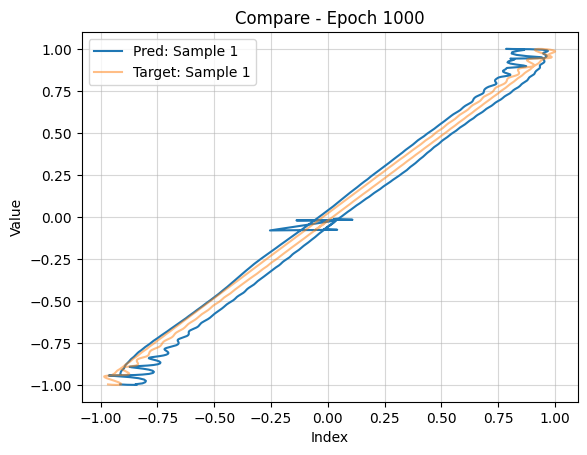

  無改善，patience_counter = 32/100
---
alpha: 0.500
Epoch 1001, loss_H: 0.002739, loss_Pcv: 0.009490
Epoch 1001 | Train Loss: 0.007132 | Val Loss: 0.006115 | Time: 5.17s
(Best Epoch 968 | best H: 0.002866| best Pcv: 0.009234| val_loss : 0.006115)
  無改善，patience_counter = 33/100
---
alpha: 0.500
Epoch 1002, loss_H: 0.002879, loss_Pcv: 0.009763
Epoch 1002 | Train Loss: 0.006424 | Val Loss: 0.006321 | Time: 5.05s
(Best Epoch 968 | best H: 0.002866| best Pcv: 0.009234| val_loss : 0.006321)
  無改善，patience_counter = 34/100
---
alpha: 0.500
Epoch 1003, loss_H: 0.002859, loss_Pcv: 0.009869
Epoch 1003 | Train Loss: 0.006350 | Val Loss: 0.006364 | Time: 5.26s
(Best Epoch 968 | best H: 0.002866| best Pcv: 0.009234| val_loss : 0.006364)
  無改善，patience_counter = 35/100
---
alpha: 0.500
Epoch 1004, loss_H: 0.002711, loss_Pcv: 0.009534
Epoch 1004 | Train Loss: 0.007048 | Val Loss: 0.006122 | Time: 4.95s
(Best Epoch 968 | best H: 0.002866| best Pcv: 0.009234| val_loss : 0.006122)
  無改善，patience_counter =

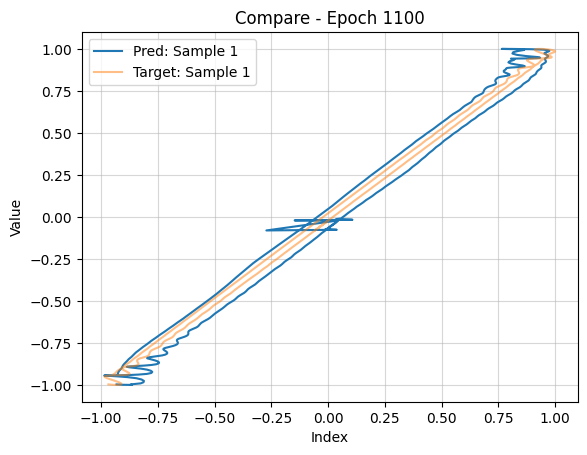

  無改善，patience_counter = 11/100
---
alpha: 0.500
Epoch 1101, loss_H: 0.003067, loss_Pcv: 0.010997
Epoch 1101 | Train Loss: 0.007559 | Val Loss: 0.007032 | Time: 5.22s
(Best Epoch 1089 | best H: 0.002768| best Pcv: 0.009264| val_loss : 0.007032)
  無改善，patience_counter = 12/100
---
alpha: 0.500
Epoch 1102, loss_H: 0.002793, loss_Pcv: 0.009548
Epoch 1102 | Train Loss: 0.006620 | Val Loss: 0.006170 | Time: 5.24s
(Best Epoch 1089 | best H: 0.002768| best Pcv: 0.009264| val_loss : 0.006170)
  無改善，patience_counter = 13/100
---
alpha: 0.500
Epoch 1103, loss_H: 0.002914, loss_Pcv: 0.009728
Epoch 1103 | Train Loss: 0.006675 | Val Loss: 0.006321 | Time: 5.01s
(Best Epoch 1089 | best H: 0.002768| best Pcv: 0.009264| val_loss : 0.006321)
  無改善，patience_counter = 14/100
---
alpha: 0.500
Epoch 1104, loss_H: 0.002784, loss_Pcv: 0.009696
Epoch 1104 | Train Loss: 0.007048 | Val Loss: 0.006240 | Time: 5.22s
(Best Epoch 1089 | best H: 0.002768| best Pcv: 0.009264| val_loss : 0.006240)
  無改善，patience_count

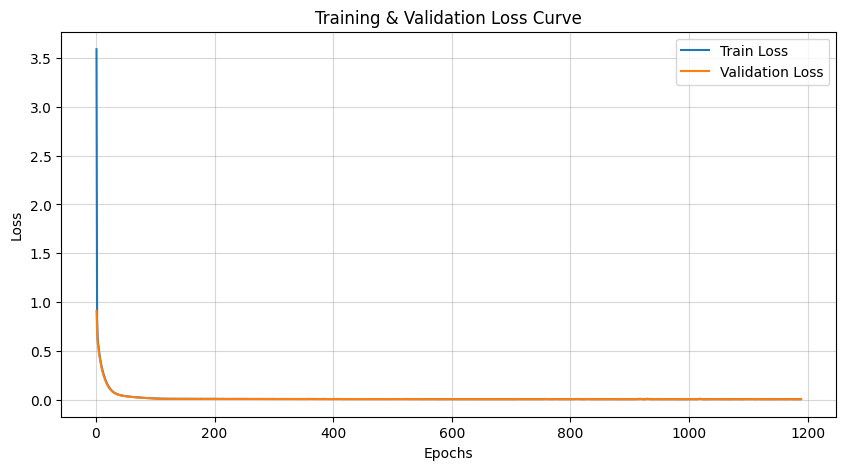

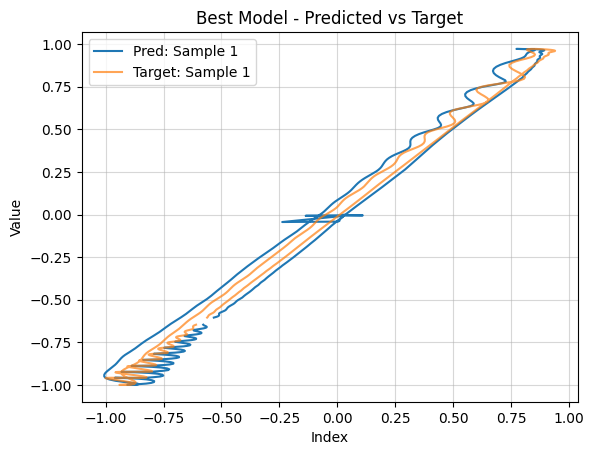

In [416]:
if __name__ == "__main__":
    main()